#  Прогнозирование заказов такси (Forecasting taxi orders)

Нам в руки попал датасет с историческими данными о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Пайплайн решения:

1. Загрузить данные и выполнить их ресемплирование.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`

## 1. Загрузка и подготовка данных

In [ ]:
#Установка зависимостей
!pip install pandas matplotlib scikit-learn numpy scipy catboost lightgbm statsmodels phik

In [1]:
import pandas as pd # основной инструмент для работы с табличными данными
import warnings # игнорирует предупреждения, чтобы не засорять вывод
warnings.simplefilter("ignore") # построение графиков для визуального анализа данных
import matplotlib.pyplot as plt
import phik # библиотека для расчета комплексной корреляции
from phik.report import plot_correlation_matrix # библиотека для расчета комплексной корреляции
from sklearn.model_selection import train_test_split # стандартное разделение на train/valid/test
from sklearn.pipeline import Pipeline # инструменты для создания конвейеров предобработки данных
from sklearn.compose import ColumnTransformer # инструменты для создания конвейеров предобработки данных
from sklearn.impute import SimpleImputer #  импьютер (заполнитель) пропущенных значений
import numpy as np # работа с многомерными массивами
from scipy import stats as st # статистики
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # преобразует категориальные признаки в бинарные (one-hot) векторы.
from sklearn.preprocessing import StandardScaler, MinMaxScaler # стандартизация данных: вычитает среднее и делит на стандартное отклонение. Среднее = 0, дисперсия = 1.
from sklearn.linear_model import LinearRegression # обычная линейная регрессия
from sklearn.metrics import mean_squared_error # вычисляет MSE (Mean Squared Error), которая затем берется в корень для получения RMSE.
from sklearn.metrics import make_scorer # позволяет создать кастомную метрику для использования в GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # инструменты для автоматического подбора гиперпараметров.
from sklearn.tree import DecisionTreeRegressor # регрессионное дерево решений. Склонно к переобучению.
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor, Pool # мощная градиентная бустинговая библиотека от Yandex, хорошо работающая с категориальными признаками "из коробки".
import lightgbm as lgb #  еще одна высокопроизводительная библиотека для градиентного бустинга от Microsoft.
from sklearn.model_selection import cross_val_score # оценка модели с помощью кросс-валидации.
from statsmodels.tsa.seasonal import seasonal_decompose # инструмент для декомпозиции временного ряда на тренд, сезонность и остаток.
from sklearn.model_selection import TimeSeriesSplit #  создает фолды так, что в каждом последующем фолде данные хронологически идут после данных предыдущего фолда.

In [2]:
# Загрузка данных
data = pd.read_csv('taxi.csv', sep=',', index_col = [0], parse_dates = [0])
display(data.head(10))
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
#Делаем ресемплирование в 1 час
data.sort_index(inplace=True)
data = data.resample('1H').sum()
display(data.head(10))
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Как видим, после ресемплирования у нас стало 4416 строк данных вместо 26496 в период с 3 марта по 31 августа 2018 года.

## 2. Анализ данных

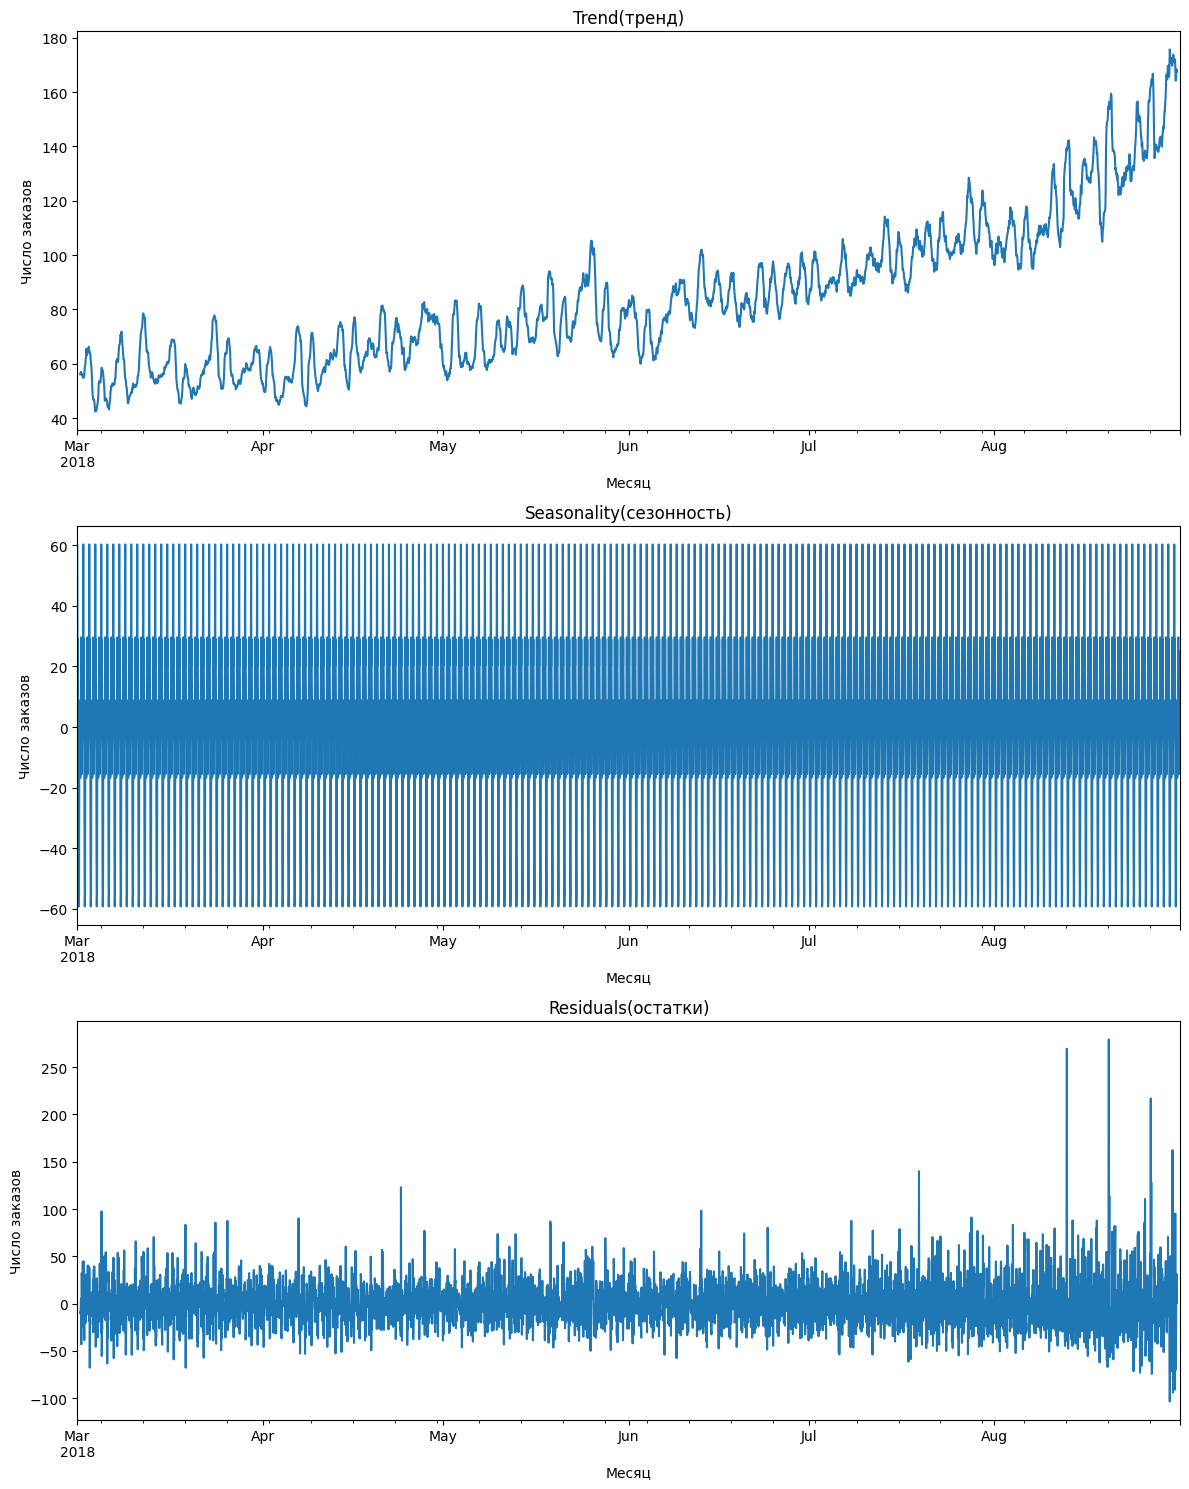

In [4]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend(тренд)')
plt.ylabel('Число заказов')
plt.xlabel('Месяц')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality(сезонность)')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals(остатки)')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.tight_layout()
plt.show()

Сверху выведены тренд, сезонная составляющая и остаток декомпозиции. Проанализировав показатели можно сделать выводы, что тренд был положительный на протяжении всего рассматриваемого периода, и пик среднего значения заказов в день пришелся на конец августа. Остатки все время находились примерно в одном диапазоне (за исключением выбросов в августе). <br/>
Теперь рассмотрим сезонность поближе. Возьмем период за одни сутки. 

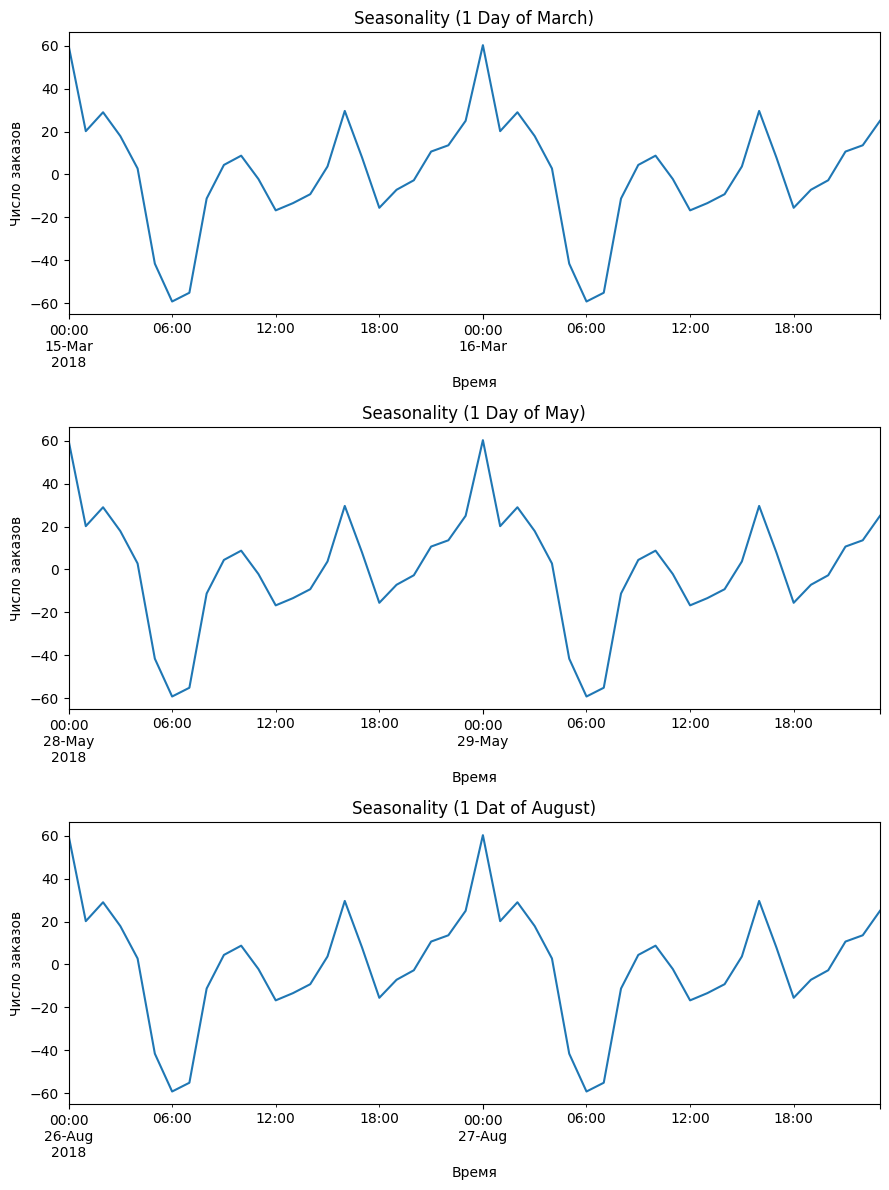

In [131]:
plt.figure(figsize=(9, 12))

plt.subplot(311)
decomposed.seasonal['2018-03-15':'2018-03-16'].plot(ax=plt.gca())
plt.title('Seasonality (1 Day of March)')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.subplot(312)
decomposed.seasonal['2018-05-28':'2018-05-29'].plot(ax=plt.gca())
plt.title('Seasonality (1 Day of May)')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.subplot(313)
decomposed.seasonal['2018-08-26':'2018-08-27'].plot(ax=plt.gca())
plt.title('Seasonality (1 Dat of August)')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.tight_layout()
plt.show()

Как видим, у нас вырисовывается четкий дневной тренд, не зависящий от месяца
По графику видно, что есть определенная закономерность когда на такси самый высокий спрос, и когда ниже всего. Так, больше всего заказов приходится на 12 ночи, а меньше всего на 6 утра

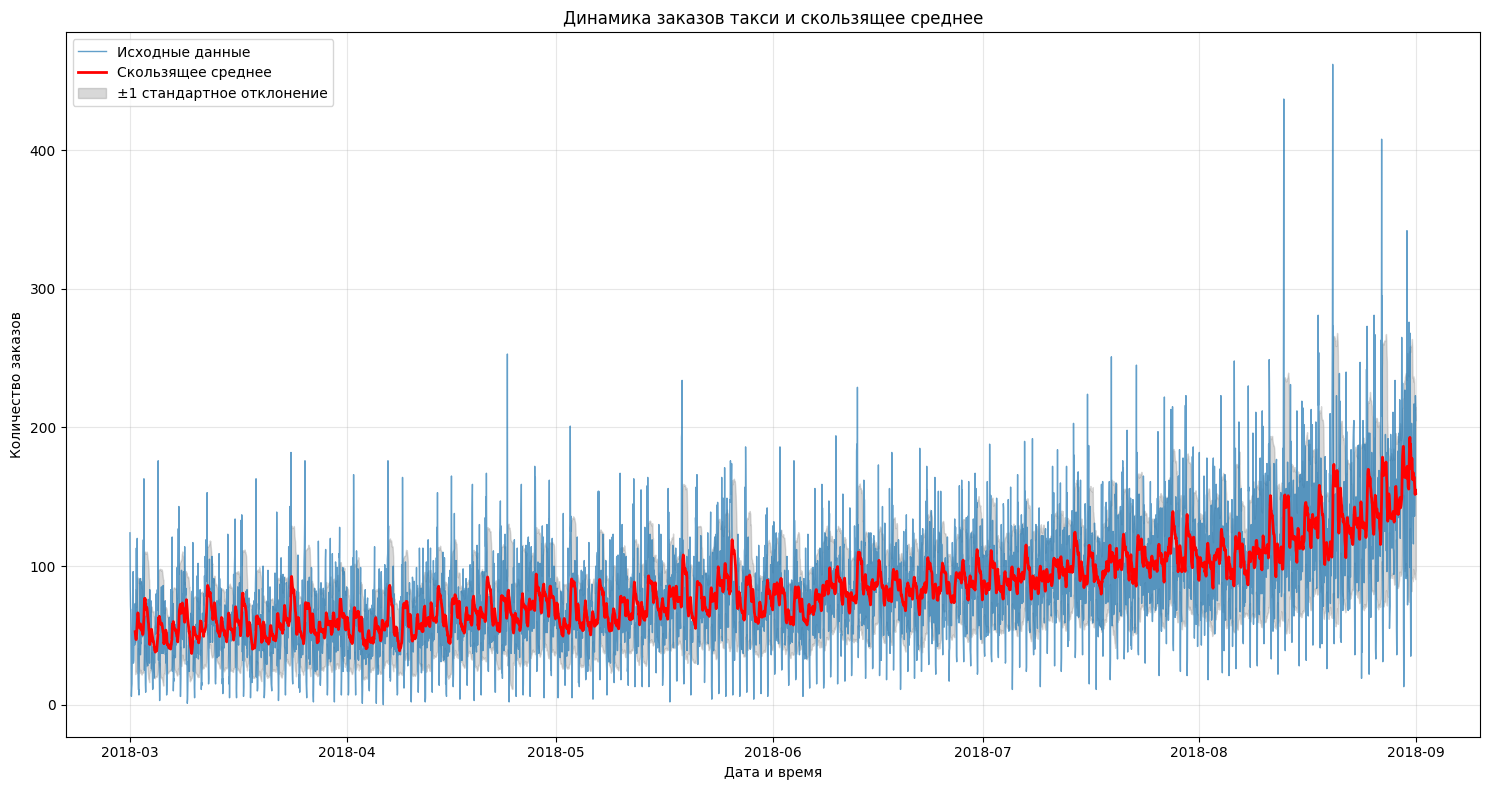

In [132]:
data1 = data.copy()
data1['rolling_mean'] = data['num_orders'].shift().rolling(18).mean()
data1['rolling_std'] = data['num_orders'].shift().rolling(18).std()

# Визуализируем
plt.figure(figsize=(15, 8))
# Исходные данные
plt.plot(data1.index, data1['num_orders'], label='Исходные данные', alpha=0.7, linewidth=1)
# Скользящее среднее
plt.plot(data1.index, data1['rolling_mean'], label=f'Скользящее среднее', linewidth=2, color='red')

# Верхняя и нижняя границы (среднее ± стандартное отклонение)
plt.fill_between(data1.index, 
                 data1['rolling_mean'] - data1['rolling_std'], 
                 data1['rolling_mean'] + data1['rolling_std'],
                 alpha=0.3, color='gray', label='±1 стандартное отклонение')

plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.title(f'Динамика заказов такси и скользящее среднее')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

По графику мы снова видим, что среднее значение плавно возрастает с марта по август, а стандартное отклоение находится примерно в одном промежутке. Ряд нестационарный потому что у него меняется среднее значение. <br/>

In [133]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(window = rolling_mean_size).mean() 
    return data

make_features(data,24,168)
data.head(10)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
num_columns = data.select_dtypes(include=['float64','int64']).columns.tolist()
phik_matrix = data.phik_matrix(interval_cols=num_columns)

interval_cols = ['day', 'dayofweek', 'hour']
num_columns = [col for col in num_columns if col not in interval_cols]

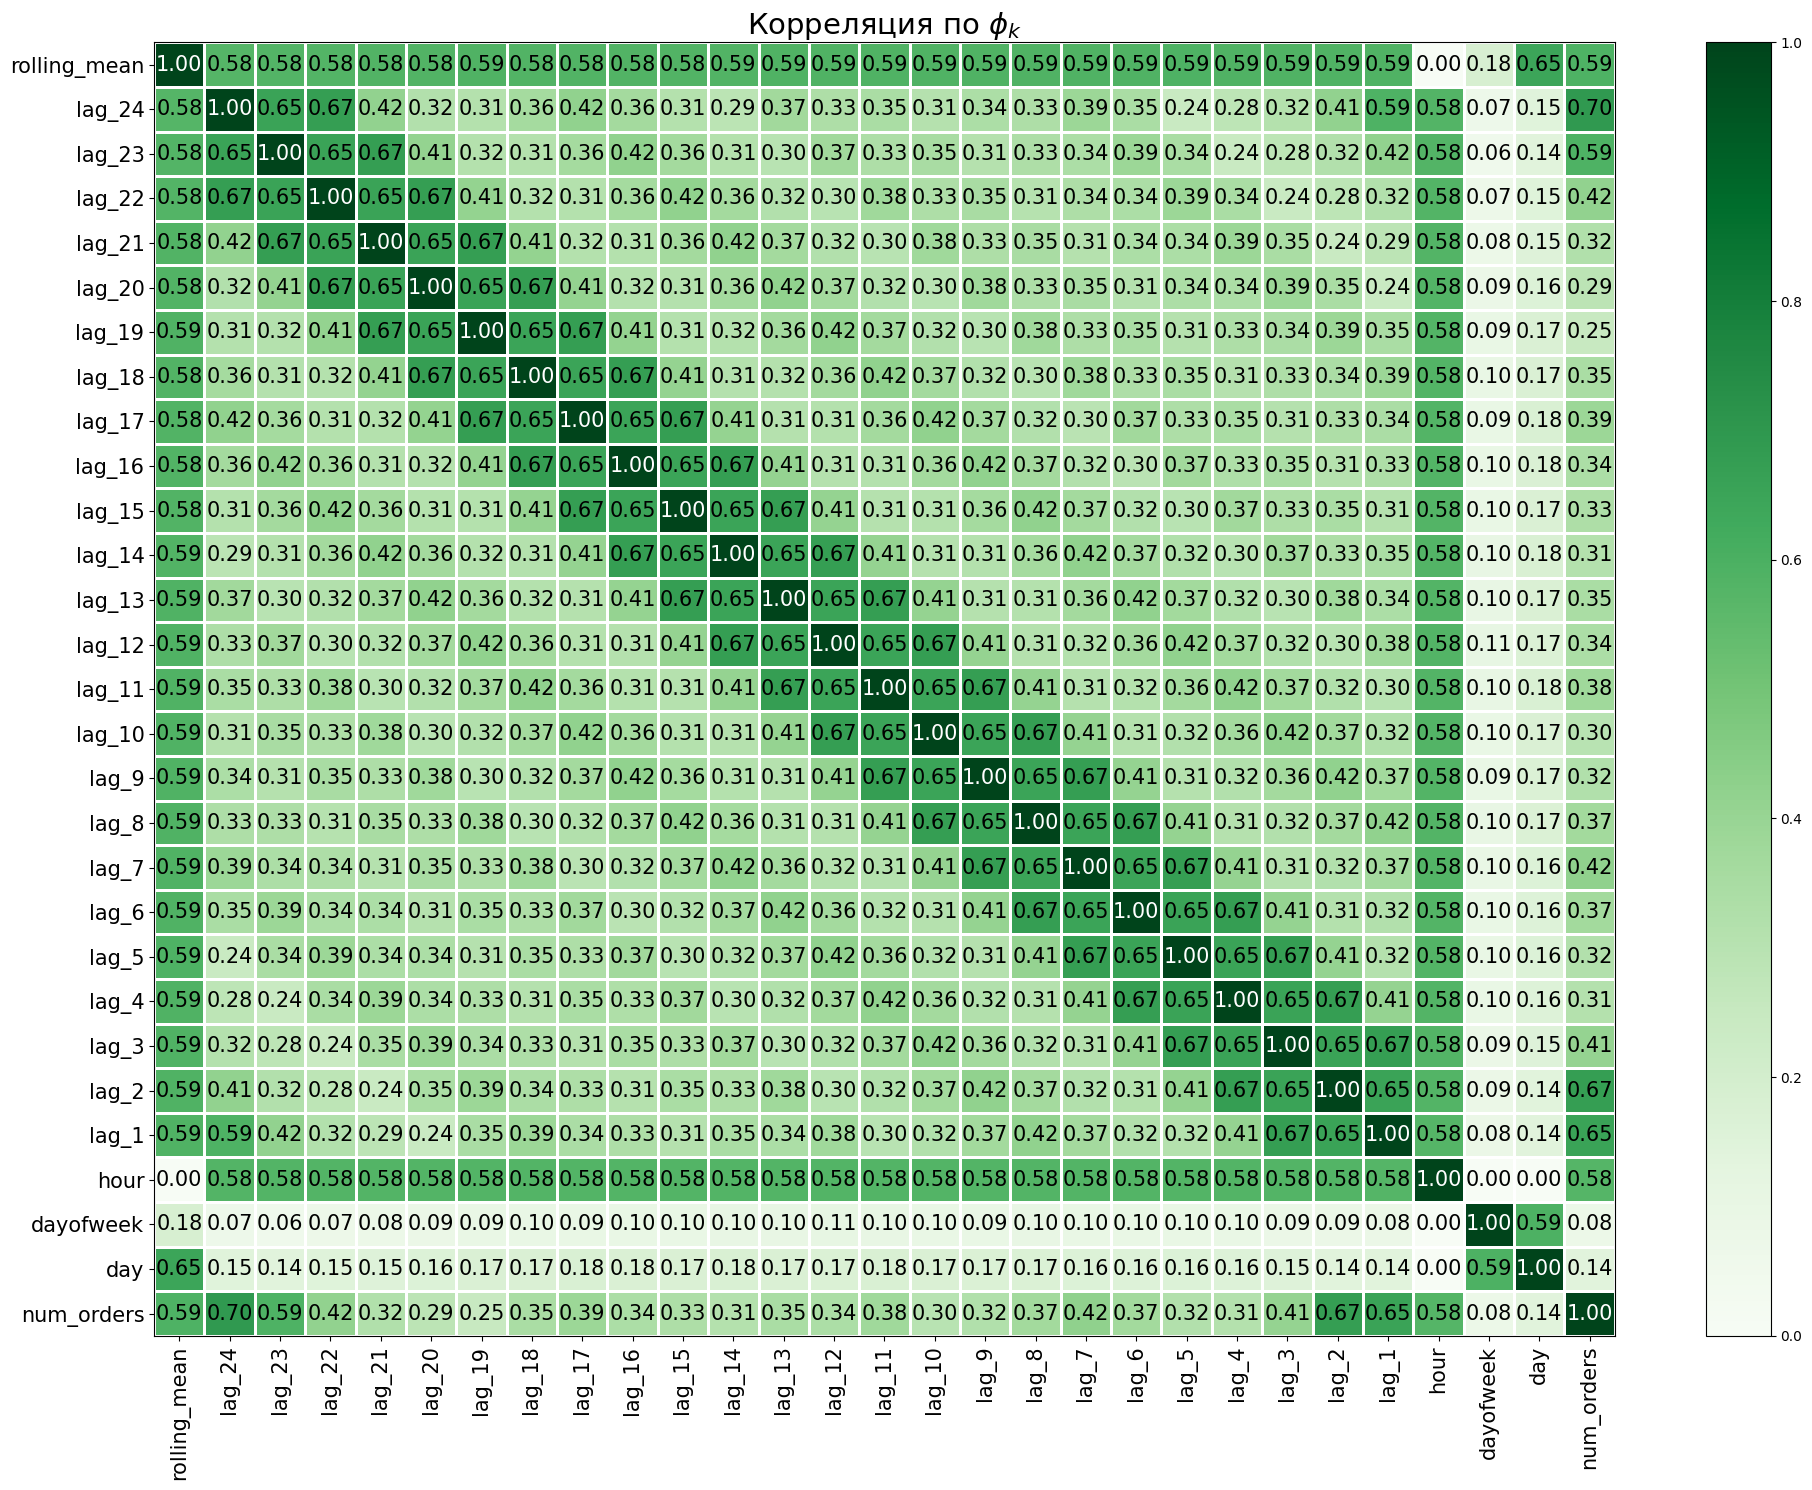

In [135]:
#строим матрицу корреляции Phik
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

По матрице корреляции видно, что больше всего на целевую переменную влияют показатели лагов за 24, 2 и 1 итерацию. Посмотрим что покажет модель

Анализ временного ряда закончен. Выводы можно сделать такие, что скорее всего ряд является стационарным, его будет довольно легко прогназировать, он имеет сезонные возрастания и падения учитывая время суток(часы), а также положтельный тренд по среднему количеству заказов в период с марта по август. Самые сильное влияние на число заказов оказывает час в сутках и месяц.

## 3. Обучение

In [136]:
RANDOM_STATE = 42

#создадим тренировочную и тестовую выборку размером 10% от всей выборки и укажем параметр, чтобы значения не перемешивались
train, test = train_test_split(data, shuffle=False, test_size=0.1)
#заодно удалим строчки с пропущенными значениями, так как они будут сбивать модель.
train = train.dropna()
#выведем минимумы и максимумы получившихся выборок
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [137]:
#выделим в выборках целевой признак
X_train = train.drop(
        ['num_orders'
        ], 
        axis=1
    )
y_train = train['num_orders']

X_test = test.drop(
        ['num_orders'
        ], 
        axis=1
    )
y_test = test['num_orders']

Для перебора параметров моделей создадим пайплайн


In [138]:
#соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную

cat_columns = ['hour', 'dayofweek', 'day']

target = 'num_orders'
num_columns = [col for col in num_columns if col not in target]

data_preprocessor = ColumnTransformer(
    [
        # Категориальные признаки: OneHotEncoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
        ]), ['hour', 'dayofweek', 'day']),
        
        # Численные признаки: Масштабирование
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # добавили импьютер для численных
            ('scaler', MinMaxScaler())
        ]), num_columns)
    ], 
    remainder='drop'
)

print(data_preprocessor)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['hour', 'dayofweek', 'day']),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
                                  'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
                                  'lag_11', 'lag_12', 'lag_13', 'lag_1

In [139]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [140]:
param_distributions = [
    {
    # словарь для модели DecisionTreeRegressor()
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(1,6),
    'models__min_samples_split': range(2,8),
    'models__min_samples_leaf': range(2, 8),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [141]:
# Используем TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)

# Создаем RandomizedSearchCV с TimeSeriesSplit
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [142]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['hour',
                                                                                'dayofweek',
                                                                                'day'...
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(1, 6),
                                         'models__min_samples_leaf': range(2, 8),
                                         'models__min_samples_split': range(2, 8),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [143]:
print ('Метрика лучшей модели на тренировочной выборке:', -randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 29.952298198596832


Создадим модель LightGMB и подберем гипермараметры для нее в пайплайне

In [144]:
# Создание трансформера для предобработки данных
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('ord', ord_pipe, cat_columns),      # категориальные
    ('num', StandardScaler(), num_columns)  # численные
])

In [145]:
# Создание модели
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, objective='regression', metric='rmse', verbosity=-1)

In [146]:
# Создание пайплайна
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [147]:
# Параметры для RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators' : range(60,80),
    'classifier__num_leaves': range(3, 10),
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': range(1,10)
}


# Создание RandomizedSearchCV
grid_search = RandomizedSearchCV(
    pipe,
    param_distributions,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_iter=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [148]:
# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ord',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['hour',
                                                                                'dayofweek',
                                                                                'day']),...
                                                                                'rolling_mean'])])),
                                             ('classifier',
                                              LGBMRegressor(metric='rmse',
                                                            objective='regression',
                                                            random_state=42,
                                                            verbosity=-1))]),
                   n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01,
                                                                      0.05, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': range(1, 10),
                                        'classifier__n_estimators': range(60, 80),
                                        'classifier__num_leaves': range(3, 10)},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [149]:
print ('Метрика лучшей модели на тренировочной выборке:', -grid_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 25.18331870886927


Обучены 2 модели и подобраны лучшие гиперпараметры для них. Выведем более подробные результаты об их работе.

In [150]:
best_model1 = randomized_search.best_estimator_.named_steps['models']
best_model2 = grid_search.best_estimator_.named_steps['classifier']


#scores = [roc_auc_cv,cv_resultsTRUE,rmse_cv]
name_of_best_models = [best_model1,best_model2]
models = [randomized_search, grid_search ]

fit_times = []
score_times = []
rmse_scores = []

# Обучение моделей и извлечение времени выполнения
for model in models:
    cv_results1 = pd.DataFrame(model.cv_results_)
    best_index = cv_results1['mean_test_score'].idxmin()
    fit_times.append(cv_results1.loc[best_index, 'mean_fit_time'])
    score_times.append(cv_results1.loc[best_index, 'mean_score_time'])
    rmse_scores.append(-model.best_score_)

# Печать результатов
for i, (fit_time, score_time,rmse_scores) in enumerate(zip(fit_times, score_times,rmse_scores), start=1):
    print(f"Показатели модели {name_of_best_models[i-1]}")
    print(f"Время обучения лучшей модели: {fit_time} секунд")
    print(f"Время предсказания лучшей модели : {score_time} секунд")
    print(f"Значение метрики RMSE на тренировочной выборке модели  : {rmse_scores}")
    print()


Показатели модели DecisionTreeRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=7,
                      random_state=42)
Время обучения лучшей модели: 0.04767694473266602 секунд
Время предсказания лучшей модели : 0.010090208053588868 секунд
Значение метрики RMSE на тренировочной выборке модели  : 29.952298198596832

Показатели модели LGBMRegressor(max_depth=9, metric='rmse', n_estimators=78, num_leaves=9,
              objective='regression', random_state=42, verbosity=-1)
Время обучения лучшей модели: 0.10671348571777343 секунд
Время предсказания лучшей модели : 0.007327365875244141 секунд
Значение метрики RMSE на тренировочной выборке модели  : 25.18331870886927



Выводы таковы, что метрика RMSE лучше у модели LightGBM, но она намного дольше обучается. В требовании говорилось только о значении метрики, поэтому лучшей будет выбрана модель, у которой это значение лучше. Для предсказания на тестовой выборке я выбираю модель LightGBM.

## 4. Тестирование

In [151]:
# Предсказание на тестовой выборке
y_pred = grid_search.predict(X_test)
# Вычисление метрики RMSE на тестовой выборке
rmse = mean_squared_error(y_test, y_pred)**0.5
print(f"Значение метрики RMSE на тестовой выборке : {rmse}")

Значение метрики RMSE на тестовой выборке : 42.1738376745172


Полученное значение метрики RMSE у выбранной модели, а именно LGBMRegressor равняется 42.17. Это значение удовлетворяет условию, меньше 48, значит задача решена.

## 5. Вывод


Лучшее качество предсказаний дает модель **LGBMRegressor с гиперпараметрами (max_depth=9, metric='rmse', n_estimators=78, num_leaves=9,objective='regression', random_state=42, verbosity=-1)**. Ее показатель метрики RMSE на тестовой выборке равен 42.17.  <br/>